In [1]:
import sys
sys.path.append('..')

In [2]:
ckpt = '2409/Hagen-indi-l1/16'
training_rootdir = '/group/jug/ashesh/training/diffsplit/'




ckpt = ckpt.strip('/').strip(' ')
ckpt

'2409/Hagen-indi-l1/16'

In [3]:
import yaml
import os
import glob

def model_checkpoint_fpath(fname=None):
    ckpt_dir = os.path.join(training_rootdir, ckpt, 'checkpoint')
    if fname is not None:
        return os.path.join(training_rootdir, ckpt, fname)
    else:
        list_of_files = glob.glob(ckpt_dir +'/*_gen.pth') # * means all if need specific format then *.csv
        latest_file = max(list_of_files, key=os.path.getctime)
        fname = latest_file
        return os.path.join(ckpt_dir,latest_file)

def model_checkpoint_fpath_prefix(fname=None):
    fpath = model_checkpoint_fpath(fname)
    suffix = '_gen.pth'
    assert fpath.endswith(suffix)
    return fpath[:-len(suffix)]

def load_config(ckpt):
    config_path = os.path.join(training_rootdir,ckpt,'wandb/latest-run/files/config.yaml')

    with open(config_path) as stream:
        try:
            opt = yaml.safe_load(stream)
        except yaml.YAMLError as exc:
            print(exc)
    
    keys = ["name","phase","gpu_ids","path","datasets","model","train","distributed"]
    return {k: opt[k]['value'] for k in keys}

In [4]:
opt = load_config(ckpt)
opt['path']['resume_state'] = model_checkpoint_fpath_prefix()
print(opt['path']['resume_state'])

/group/jug/ashesh/training/diffsplit/2409/Hagen-indi-l1/16/checkpoint/I1000000_E3125


In [5]:
opt['datasets']['val']['datapath'] = {
 'ch0': '/group/jug/ashesh/data/diffsplit_hagen/test/test_actin-60x-noise2-highsnr.tif',
 'ch1': '/group/jug/ashesh/data/diffsplit_hagen/test/test_mito-60x-noise2-highsnr.tif'
 }


In [6]:
# opt['path']['resume_state'] = '/group/jug/ashesh/training/diffsplit/2409/Hagen-indi-l1/18/checkpoint/I350000_E1094'
# opt['path']['resume_state'] = '/group/jug/ashesh/training/diffsplit/2409/Hagen-indi-l1/18/checkpoint/I380000_E1188'
# opt['path']['resume_state'] = '/group/jug/ashesh/training/diffsplit/2409/Hagen-indi-l1/18/checkpoint/I360000_E1125'


# opt['path']['resume_state'] = '/group/jug/ashesh/training/diffsplit/2409/Hagen-indi-l1/16/checkpoint/I350000_E1094'

In [7]:
if 'patch_size' not in opt['datasets']:
    opt['datasets']['patch_size']  = opt['datasets']['train']['patch_size']

if 'max_qval' not in opt['datasets']:
    opt['datasets']['max_qval']  = 0.98

if 'uncorrelated_channels' not in opt['datasets']['train']:
    opt['datasets']['train']['uncorrelated_channels']  = False

In [8]:
import torch
import data as Data
import model as Model
from data.split_dataset import SplitDataset, DataLocation
from split import get_datasets
import os


# data
train_set, val_set = get_datasets(opt, tiled_pred=True)

# model
diffusion = Model.create_model(opt)
diffusion.set_new_noise_schedule(opt['model']['beta_schedule'][opt['phase']], schedule_phase=opt['phase'])

# load checkpoint
diffusion.load_network()

INFO:albumentations.check_version:A new version of Albumentations is available: 1.4.15 (you have 1.4.7). Upgrade using: pip install --upgrade albumentations


HARDCODED upperclip to 1993. Disable it if not needed !!!
Computing mean and std for normalization
[SplitDataset] Data: 80x2x(2048, 2048) Patch:512 Random:1 Aug:True Q:0.995 UpperClip:0Uncor:True


INFO:base:Initialization method [orthogonal]


HARDCODED upperclip to 1993. Disable it if not needed !!!
[TilingDataset] Data: 10x2x(2048, 2048) Patch:512 Random:0 Aug:False Q:0.995 UpperClip:0Uncor:False
[InDI]: Sampling mode: linear_indi, Noise mode: brownian


INFO:base:Loading pretrained model for G [/group/jug/ashesh/training/diffsplit/2409/Hagen-indi-l1/16/checkpoint/I1000000_E3125] ...
INFO:base:Model [DDPM] is created.
INFO:base:Loading pretrained model for G [/group/jug/ashesh/training/diffsplit/2409/Hagen-indi-l1/16/checkpoint/I1000000_E3125] ...


0.055294544 1.2027466 0.046161562 0.07979408 0.030105382 1.2824968


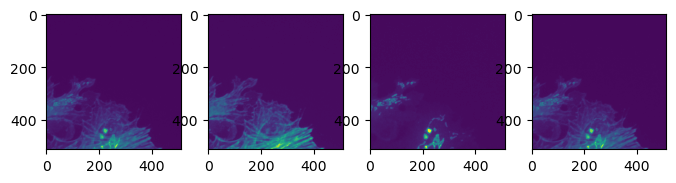

In [9]:
import matplotlib.pyplot as plt

data= train_set[0]
inp = data['input']
target = data['target']
inp = inp.transpose(1,2,0)
target = target.transpose(1,2,0)
inp = (1 + inp) / 2
target = (1 + target) / 2
is_rgb = inp.shape[-1]%3 == 0
nC = 3 if is_rgb else 1
print(inp.min(), inp.max(), target[:nC].min(), target[:nC].max(), target[nC:].min(), target[nC:].max())
_,ax = plt.subplots(figsize=(8,2),ncols=4)
ax[0].imshow(inp)
ax[1].imshow(target[...,:nC])
ax[2].imshow(target[...,nC:])
ax[3].imshow((target[...,:nC] + target[...,nC:])/2)


In [10]:
import numpy as np
import random

def fix_seeds():
    torch.manual_seed(0)
    torch.cuda.manual_seed(0)
    np.random.seed(0)
    random.seed(0)
    torch.backends.cudnn.deterministic = True

fix_seeds()

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import torch

norm_dict = val_set.get_normalization_dict()
nimgs = 6
dloader = torch.utils.data.DataLoader(
            val_set,
            batch_size=nimgs,
            shuffle=True,
            num_workers=0,
            pin_memory=True)
for data in dloader:
    break

diffusion_data = {'input': data['input'].cuda(), 'target': data['target'].cuda()}
# idx = np.random.randint(0,len(val_set), size=nimgs)
# data = val_set[idx]
# inp = data['input']
# target = data['target']
# diffusion_data = {'input': torch.Tensor(inp)[None].cuda(), 'target': torch.Tensor(target[None]).cuda()}
# inp = inp * norm_dict['std_input'] + norm_dict['mean_input']
# inp = inp/np.max(inp)
# _,ax = plt.subplots(figsize=(2,2))
# plt.imshow(inp.transpose(1,2,0))

Calling patch_location
Calling patch_location
Calling patch_location
Calling patch_location
Calling patch_location
Calling patch_location


In [12]:
def get_prediction(data_dict):
    input_unnorm, target_unnorm, pred_unnorm = get_prediction_raw(data_dict)
    target_unnorm = target_unnorm.transpose(0,2,3,1)
    pred_unnorm = pred_unnorm.transpose(0,2,3,1)
    input_unnorm = input_unnorm.transpose(0,2,3,1)
    return input_unnorm, target_unnorm, pred_unnorm

def get_prediction_raw(data_dict):
    assert 'input' in data_dict
    assert 'target' in data_dict
    assert len(data_dict['input'].shape) == 4
    assert len(data_dict['target'].shape) == 4
    diffusion.feed_data(data_dict)
    diffusion.test(continous=True, clip_denoised=False)
    visuals = diffusion.get_current_visuals()
    # input, target, prediction = unnormalize_data(visuals,train_set.get_normalization_dict())
    input = visuals['input'].cpu().numpy()
    target = visuals['target'].cpu().numpy()
    prediction = visuals['prediction'].cpu().numpy()

    # unnormalize 
    pred_unnorm = prediction * norm_dict['std_target'][None] + norm_dict['mean_target'][None]
    target_unnorm = target * norm_dict['std_target'][None] + norm_dict['mean_target'][None]
    input_unnorm = input * norm_dict['std_input'] + norm_dict['mean_input']


    if opt['datasets']['train']['name'] == 'cifar10':
        pred_unnorm[pred_unnorm<0] = 0
        pred_unnorm[pred_unnorm>255] = 255
        pred_unnorm = pred_unnorm.astype(np.uint8)
        target_unnorm = target_unnorm.astype(np.uint8)
        input_unnorm = input_unnorm.astype(np.uint16)

    return input_unnorm, target_unnorm, pred_unnorm

In [13]:
diffusion.set_new_noise_schedule(
    opt['model']['beta_schedule']['val'], schedule_phase='val')

target_arr = []
pred_arr = []
input_arr = []
for img_idx in range(nimgs):
    tmp_data = {'input': diffusion_data['input'][img_idx:img_idx+1].cuda(), 'target': diffusion_data['target'][img_idx:img_idx+1].cuda()}
    input_unnorm, target_unnorm, pred_unnorm = get_prediction(tmp_data)
    target_arr.append(target_unnorm)
    pred_arr.append(pred_unnorm[None])
    input_arr.append(input_unnorm)

inputs = np.concatenate(input_arr, axis=0)
targets = np.concatenate(target_arr, axis=0)
predictions = np.concatenate(pred_arr, axis=0)



sampling loop time step: 100%|██████████| 20/20 [00:00<00:00, 46.40it/s]


In [14]:
predictions.shape

(6, 7, 512, 512, 2)

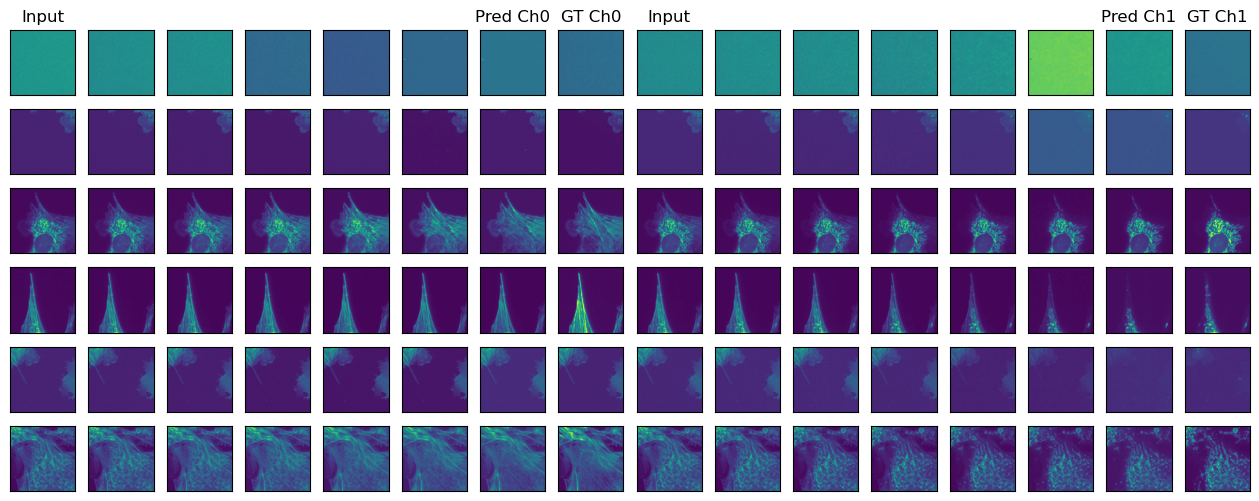

In [15]:
from disentangle.analysis.plot_utils import clean_ax
ncols = predictions.shape[1] + 1
assert nimgs % 2 == 0
nrows = 2*nimgs
dfac = 1
# rgb = target_unnorm.shape[-1]
_,ax = plt.subplots(figsize=(ncols*1*2,nrows*1//2), ncols=ncols*2, nrows=nrows//2)
ax = ax.reshape(nrows,ncols)
for img_idx in range(nimgs):
    for i in range(predictions.shape[1]):
        ax[0+img_idx*2,i].imshow(predictions[img_idx,i,::dfac,::dfac,:nC])
        ax[1+img_idx*2,i].imshow(predictions[img_idx,i,::dfac,::dfac,nC:])

    ax[0+img_idx*2,-1].imshow(targets[img_idx,::dfac,::dfac,:nC])
    ax[1+img_idx*2,-1].imshow(targets[img_idx,::dfac,::dfac,nC:])

ax[0,-1].set_title('GT Ch0')
ax[0,0].set_title('Input')
ax[0,-2].set_title('Pred Ch0')

ax[1,-1].set_title('GT Ch1')
ax[1,0].set_title('Input')
ax[1,-2].set_title('Pred Ch1')

clean_ax(ax)

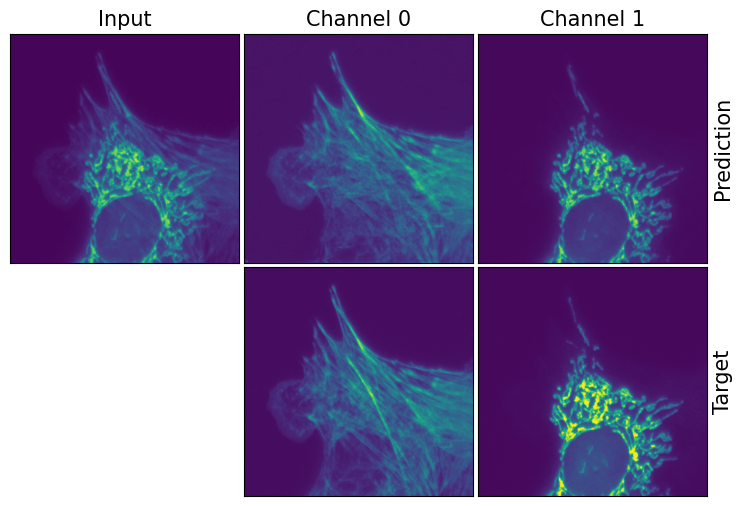

In [16]:
import matplotlib.pyplot as plt 
from disentangle.analysis.plot_utils import clean_ax
img_idx = 2
pred_tmp = predictions[img_idx,-1]
target_tmp = targets[img_idx]
input_tmp = inputs[img_idx]
rgb_ch = target_tmp.shape[-1]

_,ax = plt.subplots(figsize=(9,6),ncols=3,nrows=2)
ax[0,0].set_title('Input', fontsize=15)
ax[1,0].axis('off')



ax[0,1].set_title('Channel 0', fontsize=15)
ax[0,2].set_title('Channel 1', fontsize=15)
ax[0,2].set_ylabel('Prediction', fontsize=15)
ax[1,2].set_ylabel('Target', fontsize=15)
ax[0,2].yaxis.set_label_position("right")
ax[1,2].yaxis.set_label_position("right")


ax[0,0].imshow(input_tmp)
ax[0,1].imshow(pred_tmp[...,:rgb_ch//2])
ax[1,1].imshow(target_tmp[...,:rgb_ch//2])

ax[0,2].imshow(pred_tmp[...,rgb_ch//2:])
ax[1,2].imshow(target_tmp[...,rgb_ch//2:])
clean_ax(ax)
# remove the space between the subplots
plt.subplots_adjust(wspace=0.02, hspace=0.02)

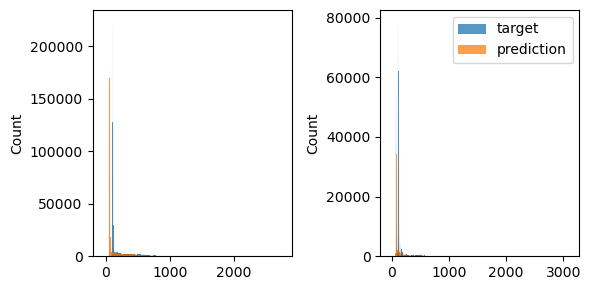

In [17]:
import seaborn as sns
ncols = predictions.shape[-1]
_,ax = plt.subplots(figsize=(3*ncols,3),ncols=ncols)
for ch_idx in range(ncols):
    sns.histplot(targets[:,...,ch_idx].reshape(-1,), label='target',ax=ax[ch_idx])
    sns.histplot(predictions[:,-1,...,ch_idx].reshape(-1,), label='prediction', ax=ax[ch_idx])
plt.legend()
plt.tight_layout()

## Metrics

In [18]:
nC

1

In [19]:
from core.psnr import PSNR
from collections import defaultdict
from tqdm import tqdm

psnr_dict = defaultdict(list)
all_predictions = []
all_targets = []
for i in tqdm(range(len(val_set))):
    data = val_set[i]
    diffusion_data = {'input': torch.Tensor(data['input'])[None].cuda(), 
                      'target': torch.Tensor(data['target'][None]).cuda()
                      }
    input_unnorm, target_unnorm, pred_unnorm = get_prediction_raw(diffusion_data);
    all_predictions.append(pred_unnorm[-1:])
    all_targets.append(target_unnorm)
    
    ch0_psnr = torch.mean(PSNR(pred_unnorm[-1,...,:nC].transpose(2,0,1), target_unnorm[0,...,:nC].transpose(2,0,1))).item()
    ch1_psnr = torch.mean(PSNR(pred_unnorm[-1,...,nC:].transpose(2,0,1), target_unnorm[0,...,nC:].transpose(2,0,1))).item()
    psnr_dict['ch0'].append(ch0_psnr)
    psnr_dict['ch1'].append(ch1_psnr)
    

  0%|          | 0/490 [00:00<?, ?it/s]

Calling patch_location


  0%|          | 1/490 [00:00<03:40,  2.22it/s]

Calling patch_location


  0%|          | 2/490 [00:00<03:38,  2.23it/s]

Calling patch_location


  1%|          | 3/490 [00:01<03:35,  2.26it/s]

Calling patch_location


  1%|          | 4/490 [00:01<03:35,  2.25it/s]

Calling patch_location


  1%|          | 5/490 [00:02<03:53,  2.07it/s]

Calling patch_location


  1%|          | 6/490 [00:02<03:48,  2.12it/s]

Calling patch_location


  1%|▏         | 7/490 [00:03<03:42,  2.18it/s]

Calling patch_location


  2%|▏         | 8/490 [00:03<03:38,  2.20it/s]

Calling patch_location


  2%|▏         | 9/490 [00:04<03:36,  2.22it/s]

Calling patch_location


  2%|▏         | 10/490 [00:04<03:35,  2.23it/s]

Calling patch_location


  2%|▏         | 11/490 [00:04<03:32,  2.25it/s]

Calling patch_location


  2%|▏         | 12/490 [00:05<03:32,  2.25it/s]

Calling patch_location


  3%|▎         | 13/490 [00:05<03:30,  2.26it/s]

Calling patch_location


  3%|▎         | 14/490 [00:06<03:31,  2.26it/s]

Calling patch_location


  3%|▎         | 15/490 [00:06<03:30,  2.26it/s]

Calling patch_location


  3%|▎         | 16/490 [00:07<03:28,  2.27it/s]

Calling patch_location


  3%|▎         | 17/490 [00:07<03:28,  2.27it/s]

Calling patch_location


  4%|▎         | 18/490 [00:08<03:29,  2.25it/s]

Calling patch_location


  4%|▍         | 19/490 [00:08<03:27,  2.27it/s]

Calling patch_location


  4%|▍         | 20/490 [00:08<03:27,  2.26it/s]

Calling patch_location


  4%|▍         | 21/490 [00:09<03:26,  2.28it/s]

Calling patch_location


  4%|▍         | 22/490 [00:09<03:26,  2.26it/s]

Calling patch_location


  5%|▍         | 23/490 [00:10<03:25,  2.27it/s]

Calling patch_location


  5%|▍         | 24/490 [00:10<03:27,  2.25it/s]

Calling patch_location


  5%|▌         | 25/490 [00:11<03:27,  2.24it/s]

Calling patch_location


  5%|▌         | 26/490 [00:11<03:28,  2.22it/s]

Calling patch_location


  6%|▌         | 27/490 [00:12<03:27,  2.23it/s]

Calling patch_location


  6%|▌         | 28/490 [00:12<03:24,  2.25it/s]

Calling patch_location


  6%|▌         | 29/490 [00:12<03:23,  2.27it/s]

Calling patch_location


  6%|▌         | 30/490 [00:13<03:23,  2.26it/s]

Calling patch_location


  6%|▋         | 31/490 [00:13<03:22,  2.27it/s]

Calling patch_location


  7%|▋         | 32/490 [00:14<03:21,  2.27it/s]

Calling patch_location


  7%|▋         | 33/490 [00:14<03:20,  2.28it/s]

Calling patch_location


  7%|▋         | 34/490 [00:15<03:20,  2.28it/s]

Calling patch_location


  7%|▋         | 35/490 [00:15<03:20,  2.27it/s]

Calling patch_location


  7%|▋         | 36/490 [00:16<03:19,  2.28it/s]

Calling patch_location


  8%|▊         | 37/490 [00:16<03:19,  2.27it/s]

Calling patch_location


  8%|▊         | 38/490 [00:16<03:19,  2.27it/s]

Calling patch_location


  8%|▊         | 39/490 [00:17<03:19,  2.26it/s]

Calling patch_location


  8%|▊         | 40/490 [00:17<03:18,  2.26it/s]

Calling patch_location


  8%|▊         | 41/490 [00:18<03:19,  2.25it/s]

Calling patch_location


  9%|▊         | 42/490 [00:18<03:18,  2.26it/s]

Calling patch_location


  9%|▉         | 43/490 [00:19<03:17,  2.26it/s]

Calling patch_location


  9%|▉         | 44/490 [00:19<03:17,  2.26it/s]

Calling patch_location


  9%|▉         | 45/490 [00:20<03:16,  2.27it/s]

Calling patch_location


  9%|▉         | 46/490 [00:20<03:16,  2.26it/s]

Calling patch_location


 10%|▉         | 47/490 [00:20<03:15,  2.26it/s]

Calling patch_location


 10%|▉         | 48/490 [00:21<03:14,  2.27it/s]

Calling patch_location


 10%|█         | 49/490 [00:21<03:14,  2.27it/s]

Calling patch_location


 10%|█         | 50/490 [00:22<03:13,  2.27it/s]

Calling patch_location


 10%|█         | 51/490 [00:22<03:13,  2.27it/s]

Calling patch_location


 11%|█         | 52/490 [00:23<03:13,  2.27it/s]

Calling patch_location


 11%|█         | 53/490 [00:23<03:13,  2.26it/s]

Calling patch_location


 11%|█         | 54/490 [00:23<03:12,  2.26it/s]

Calling patch_location


 11%|█         | 55/490 [00:24<03:12,  2.26it/s]

Calling patch_location


 11%|█▏        | 56/490 [00:24<03:11,  2.26it/s]

Calling patch_location


 12%|█▏        | 57/490 [00:25<03:11,  2.26it/s]

Calling patch_location


 12%|█▏        | 58/490 [00:25<03:10,  2.27it/s]

Calling patch_location


 12%|█▏        | 59/490 [00:26<03:09,  2.28it/s]

Calling patch_location


 12%|█▏        | 60/490 [00:26<03:08,  2.28it/s]

Calling patch_location


 12%|█▏        | 61/490 [00:27<03:09,  2.26it/s]

Calling patch_location


 13%|█▎        | 62/490 [00:27<03:09,  2.26it/s]

Calling patch_location


 13%|█▎        | 63/490 [00:27<03:08,  2.26it/s]

Calling patch_location


 13%|█▎        | 64/490 [00:28<03:08,  2.26it/s]

Calling patch_location


 13%|█▎        | 65/490 [00:28<03:08,  2.26it/s]

Calling patch_location


 13%|█▎        | 66/490 [00:29<03:07,  2.26it/s]

Calling patch_location


 14%|█▎        | 67/490 [00:29<03:06,  2.26it/s]

Calling patch_location


 14%|█▍        | 68/490 [00:30<03:05,  2.27it/s]

Calling patch_location


 14%|█▍        | 69/490 [00:30<03:05,  2.27it/s]

Calling patch_location


 14%|█▍        | 70/490 [00:31<03:04,  2.27it/s]

Calling patch_location


 14%|█▍        | 71/490 [00:31<03:04,  2.27it/s]

Calling patch_location


 15%|█▍        | 72/490 [00:31<03:03,  2.28it/s]

Calling patch_location


 15%|█▍        | 73/490 [00:32<03:03,  2.28it/s]

Calling patch_location


 15%|█▌        | 74/490 [00:32<03:02,  2.27it/s]

Calling patch_location


 15%|█▌        | 75/490 [00:33<03:02,  2.27it/s]

Calling patch_location


 16%|█▌        | 76/490 [00:33<03:02,  2.27it/s]

Calling patch_location


 16%|█▌        | 77/490 [00:34<03:02,  2.26it/s]

Calling patch_location


 16%|█▌        | 78/490 [00:34<03:01,  2.27it/s]

Calling patch_location


 16%|█▌        | 79/490 [00:35<03:02,  2.26it/s]

Calling patch_location


 16%|█▋        | 80/490 [00:35<03:01,  2.26it/s]

Calling patch_location


 17%|█▋        | 81/490 [00:35<03:00,  2.27it/s]

Calling patch_location


 17%|█▋        | 82/490 [00:36<02:59,  2.27it/s]

Calling patch_location


 17%|█▋        | 83/490 [00:36<03:00,  2.26it/s]

Calling patch_location


 17%|█▋        | 84/490 [00:37<02:58,  2.27it/s]

Calling patch_location


 17%|█▋        | 85/490 [00:37<02:58,  2.26it/s]

Calling patch_location


 18%|█▊        | 86/490 [00:38<02:57,  2.27it/s]

Calling patch_location


 18%|█▊        | 87/490 [00:38<02:57,  2.27it/s]

Calling patch_location


 18%|█▊        | 88/490 [00:38<02:57,  2.27it/s]

Calling patch_location


 18%|█▊        | 89/490 [00:39<02:55,  2.28it/s]

Calling patch_location


 18%|█▊        | 90/490 [00:39<02:55,  2.28it/s]

Calling patch_location


 19%|█▊        | 91/490 [00:40<02:55,  2.27it/s]

Calling patch_location


 19%|█▉        | 92/490 [00:40<02:55,  2.26it/s]

Calling patch_location


 19%|█▉        | 93/490 [00:41<02:56,  2.26it/s]

Calling patch_location


 19%|█▉        | 94/490 [00:41<02:55,  2.26it/s]

Calling patch_location


 19%|█▉        | 95/490 [00:42<02:54,  2.27it/s]

Calling patch_location


 20%|█▉        | 96/490 [00:42<02:53,  2.27it/s]

Calling patch_location


 20%|█▉        | 97/490 [00:42<02:53,  2.27it/s]

Calling patch_location


 20%|██        | 98/490 [00:43<02:52,  2.28it/s]

Calling patch_location


 20%|██        | 99/490 [00:43<02:52,  2.27it/s]

Calling patch_location


 20%|██        | 100/490 [00:44<02:51,  2.28it/s]

Calling patch_location


 21%|██        | 101/490 [00:44<02:50,  2.29it/s]

Calling patch_location


 21%|██        | 102/490 [00:45<02:51,  2.26it/s]

Calling patch_location


 21%|██        | 103/490 [00:45<02:50,  2.27it/s]

Calling patch_location


 21%|██        | 104/490 [00:46<02:49,  2.28it/s]

Calling patch_location


 21%|██▏       | 105/490 [00:46<02:48,  2.28it/s]

Calling patch_location


 22%|██▏       | 106/490 [00:46<02:47,  2.29it/s]

Calling patch_location


 22%|██▏       | 107/490 [00:47<02:47,  2.29it/s]

Calling patch_location


 22%|██▏       | 108/490 [00:47<02:47,  2.28it/s]

Calling patch_location


 22%|██▏       | 109/490 [00:48<02:47,  2.27it/s]

Calling patch_location


 22%|██▏       | 110/490 [00:48<02:48,  2.26it/s]

Calling patch_location


 23%|██▎       | 111/490 [00:49<02:48,  2.25it/s]

Calling patch_location


 23%|██▎       | 112/490 [00:49<02:47,  2.26it/s]

Calling patch_location


 23%|██▎       | 113/490 [00:49<02:47,  2.25it/s]

Calling patch_location


 23%|██▎       | 114/490 [00:50<02:46,  2.25it/s]

Calling patch_location


 23%|██▎       | 115/490 [00:50<02:45,  2.26it/s]

Calling patch_location


 24%|██▎       | 116/490 [00:51<02:46,  2.25it/s]

Calling patch_location


 24%|██▍       | 117/490 [00:51<02:45,  2.25it/s]

Calling patch_location


 24%|██▍       | 118/490 [00:52<02:44,  2.26it/s]

Calling patch_location


 24%|██▍       | 119/490 [00:52<02:44,  2.25it/s]

Calling patch_location


 24%|██▍       | 120/490 [00:53<02:43,  2.27it/s]

Calling patch_location


 25%|██▍       | 121/490 [00:53<02:42,  2.27it/s]

Calling patch_location


 25%|██▍       | 122/490 [00:53<02:42,  2.27it/s]

Calling patch_location


 25%|██▌       | 123/490 [00:54<02:41,  2.27it/s]

Calling patch_location


 25%|██▌       | 124/490 [00:54<02:41,  2.27it/s]

Calling patch_location


 26%|██▌       | 125/490 [00:55<02:40,  2.27it/s]

Calling patch_location


 26%|██▌       | 126/490 [00:55<02:40,  2.27it/s]

Calling patch_location


 26%|██▌       | 127/490 [00:56<02:39,  2.27it/s]

Calling patch_location


 26%|██▌       | 128/490 [00:56<02:39,  2.28it/s]

Calling patch_location


 26%|██▋       | 129/490 [00:57<02:39,  2.27it/s]

Calling patch_location


 27%|██▋       | 130/490 [00:57<02:37,  2.28it/s]

Calling patch_location


 27%|██▋       | 131/490 [00:57<02:37,  2.27it/s]

Calling patch_location


 27%|██▋       | 132/490 [00:58<02:37,  2.27it/s]

Calling patch_location


 27%|██▋       | 133/490 [00:58<02:37,  2.27it/s]

Calling patch_location


 27%|██▋       | 134/490 [00:59<02:36,  2.28it/s]

Calling patch_location


 28%|██▊       | 135/490 [00:59<02:35,  2.28it/s]

Calling patch_location


 28%|██▊       | 136/490 [01:00<02:35,  2.28it/s]

Calling patch_location


 28%|██▊       | 137/490 [01:00<02:34,  2.28it/s]

Calling patch_location


 28%|██▊       | 138/490 [01:00<02:34,  2.27it/s]

Calling patch_location


 28%|██▊       | 139/490 [01:01<02:34,  2.27it/s]

Calling patch_location


 29%|██▊       | 140/490 [01:01<02:34,  2.27it/s]

Calling patch_location


 29%|██▉       | 141/490 [01:02<02:33,  2.28it/s]

Calling patch_location


 29%|██▉       | 142/490 [01:02<02:32,  2.28it/s]

Calling patch_location


 29%|██▉       | 143/490 [01:03<02:32,  2.28it/s]

Calling patch_location


 29%|██▉       | 144/490 [01:03<02:31,  2.29it/s]

Calling patch_location


 30%|██▉       | 145/490 [01:04<02:31,  2.28it/s]

Calling patch_location


 30%|██▉       | 146/490 [01:04<02:30,  2.28it/s]

Calling patch_location


 30%|███       | 147/490 [01:04<02:30,  2.28it/s]

Calling patch_location


 30%|███       | 148/490 [01:05<02:29,  2.28it/s]

Calling patch_location


 30%|███       | 149/490 [01:05<02:29,  2.28it/s]

Calling patch_location


 31%|███       | 150/490 [01:06<02:29,  2.27it/s]

Calling patch_location


 31%|███       | 151/490 [01:06<02:29,  2.26it/s]

Calling patch_location


 31%|███       | 152/490 [01:07<02:29,  2.27it/s]

Calling patch_location


 31%|███       | 153/490 [01:07<02:28,  2.27it/s]

Calling patch_location


 31%|███▏      | 154/490 [01:08<02:27,  2.28it/s]

Calling patch_location


 32%|███▏      | 155/490 [01:08<02:28,  2.26it/s]

Calling patch_location


 32%|███▏      | 156/490 [01:08<02:27,  2.27it/s]

Calling patch_location


 32%|███▏      | 157/490 [01:09<02:26,  2.27it/s]

Calling patch_location


 32%|███▏      | 158/490 [01:09<02:25,  2.27it/s]

Calling patch_location


 32%|███▏      | 159/490 [01:10<02:26,  2.26it/s]

Calling patch_location


 33%|███▎      | 160/490 [01:10<02:25,  2.27it/s]

Calling patch_location


 33%|███▎      | 161/490 [01:11<02:25,  2.26it/s]

Calling patch_location


 33%|███▎      | 162/490 [01:11<02:25,  2.26it/s]

Calling patch_location


 33%|███▎      | 163/490 [01:11<02:24,  2.27it/s]

Calling patch_location


 33%|███▎      | 164/490 [01:12<02:26,  2.22it/s]

Calling patch_location


 34%|███▎      | 165/490 [01:12<02:25,  2.23it/s]

Calling patch_location


 34%|███▍      | 166/490 [01:13<02:24,  2.24it/s]

Calling patch_location


 34%|███▍      | 167/490 [01:13<02:24,  2.24it/s]

Calling patch_location


 34%|███▍      | 168/490 [01:14<02:23,  2.24it/s]

Calling patch_location


 34%|███▍      | 169/490 [01:14<02:22,  2.26it/s]

Calling patch_location


 35%|███▍      | 170/490 [01:15<02:21,  2.27it/s]

Calling patch_location


 35%|███▍      | 171/490 [01:15<02:20,  2.26it/s]

Calling patch_location


 35%|███▌      | 172/490 [01:16<02:20,  2.26it/s]

Calling patch_location


 35%|███▌      | 173/490 [01:16<02:20,  2.25it/s]

Calling patch_location


 36%|███▌      | 174/490 [01:16<02:20,  2.24it/s]

Calling patch_location


 36%|███▌      | 175/490 [01:17<02:19,  2.26it/s]

Calling patch_location


 36%|███▌      | 176/490 [01:17<02:18,  2.27it/s]

Calling patch_location


 36%|███▌      | 177/490 [01:18<02:17,  2.27it/s]

Calling patch_location


 36%|███▋      | 178/490 [01:18<02:17,  2.27it/s]

Calling patch_location


 37%|███▋      | 179/490 [01:19<02:16,  2.27it/s]

Calling patch_location


 37%|███▋      | 180/490 [01:19<02:16,  2.28it/s]

Calling patch_location


 37%|███▋      | 181/490 [01:19<02:16,  2.27it/s]

Calling patch_location


 37%|███▋      | 182/490 [01:20<02:16,  2.26it/s]

Calling patch_location


 37%|███▋      | 183/490 [01:20<02:15,  2.26it/s]

Calling patch_location


 38%|███▊      | 184/490 [01:21<02:14,  2.27it/s]

Calling patch_location


 38%|███▊      | 185/490 [01:21<02:14,  2.27it/s]

Calling patch_location


 38%|███▊      | 186/490 [01:22<02:13,  2.28it/s]

Calling patch_location


 38%|███▊      | 187/490 [01:22<02:13,  2.27it/s]

Calling patch_location


 38%|███▊      | 188/490 [01:23<02:25,  2.08it/s]

Calling patch_location


 39%|███▊      | 189/490 [01:23<02:36,  1.92it/s]

Calling patch_location


 39%|███▉      | 190/490 [01:24<02:54,  1.72it/s]

Calling patch_location


 39%|███▉      | 191/490 [01:25<02:50,  1.76it/s]

Calling patch_location


 39%|███▉      | 192/490 [01:25<02:46,  1.79it/s]

Calling patch_location


 39%|███▉      | 193/490 [01:26<02:49,  1.75it/s]

Calling patch_location


 40%|███▉      | 194/490 [01:26<02:42,  1.82it/s]

Calling patch_location


 40%|███▉      | 195/490 [01:27<02:37,  1.87it/s]

Calling patch_location


 40%|████      | 196/490 [01:27<02:36,  1.88it/s]

Calling patch_location


 40%|████      | 197/490 [01:28<02:30,  1.94it/s]

Calling patch_location


 40%|████      | 198/490 [01:28<02:24,  2.02it/s]

Calling patch_location


 41%|████      | 199/490 [01:29<02:18,  2.10it/s]

Calling patch_location


 41%|████      | 200/490 [01:29<02:15,  2.14it/s]

Calling patch_location


 41%|████      | 201/490 [01:29<02:12,  2.17it/s]

Calling patch_location


 41%|████      | 202/490 [01:30<02:10,  2.20it/s]

Calling patch_location


 41%|████▏     | 203/490 [01:30<02:09,  2.22it/s]

Calling patch_location


 42%|████▏     | 204/490 [01:31<02:07,  2.23it/s]

Calling patch_location


 42%|████▏     | 205/490 [01:31<02:17,  2.07it/s]

Calling patch_location


 42%|████▏     | 206/490 [01:32<02:25,  1.95it/s]

Calling patch_location


 42%|████▏     | 207/490 [01:32<02:19,  2.03it/s]

Calling patch_location


 42%|████▏     | 208/490 [01:33<02:14,  2.10it/s]

Calling patch_location


 43%|████▎     | 209/490 [01:33<02:10,  2.15it/s]

Calling patch_location


 43%|████▎     | 210/490 [01:34<02:08,  2.18it/s]

Calling patch_location


 43%|████▎     | 211/490 [01:34<02:06,  2.21it/s]

Calling patch_location


 43%|████▎     | 212/490 [01:35<02:04,  2.23it/s]

Calling patch_location


 43%|████▎     | 213/490 [01:35<02:04,  2.23it/s]

Calling patch_location


 44%|████▎     | 214/490 [01:35<02:02,  2.25it/s]

Calling patch_location


 44%|████▍     | 215/490 [01:36<02:01,  2.25it/s]

Calling patch_location


 44%|████▍     | 216/490 [01:36<02:01,  2.26it/s]

Calling patch_location


 44%|████▍     | 217/490 [01:37<02:00,  2.27it/s]

Calling patch_location


 44%|████▍     | 218/490 [01:37<02:00,  2.26it/s]

Calling patch_location


 45%|████▍     | 219/490 [01:38<01:59,  2.27it/s]

Calling patch_location


 45%|████▍     | 220/490 [01:38<01:59,  2.26it/s]

Calling patch_location


 45%|████▌     | 221/490 [01:39<01:58,  2.26it/s]

Calling patch_location


 45%|████▌     | 222/490 [01:39<01:58,  2.26it/s]

Calling patch_location


 46%|████▌     | 223/490 [01:39<01:57,  2.27it/s]

Calling patch_location


 46%|████▌     | 224/490 [01:40<01:56,  2.28it/s]

Calling patch_location


 46%|████▌     | 225/490 [01:40<01:56,  2.28it/s]

Calling patch_location


 46%|████▌     | 226/490 [01:41<01:56,  2.26it/s]

Calling patch_location


 46%|████▋     | 227/490 [01:41<01:55,  2.27it/s]

Calling patch_location


 47%|████▋     | 228/490 [01:42<01:55,  2.26it/s]

Calling patch_location


 47%|████▋     | 229/490 [01:42<01:54,  2.27it/s]

Calling patch_location


 47%|████▋     | 230/490 [01:43<01:53,  2.28it/s]

Calling patch_location


 47%|████▋     | 231/490 [01:43<01:53,  2.28it/s]

Calling patch_location


 47%|████▋     | 232/490 [01:43<01:53,  2.28it/s]

Calling patch_location


 48%|████▊     | 233/490 [01:44<01:52,  2.28it/s]

Calling patch_location


 48%|████▊     | 234/490 [01:44<01:52,  2.28it/s]

Calling patch_location


 48%|████▊     | 235/490 [01:45<01:51,  2.28it/s]

Calling patch_location


 48%|████▊     | 236/490 [01:45<01:51,  2.28it/s]

Calling patch_location


 48%|████▊     | 237/490 [01:46<01:51,  2.27it/s]

Calling patch_location


 49%|████▊     | 238/490 [01:46<01:50,  2.27it/s]

Calling patch_location


 49%|████▉     | 239/490 [01:46<01:50,  2.27it/s]

Calling patch_location


 49%|████▉     | 240/490 [01:47<01:49,  2.28it/s]

Calling patch_location


 49%|████▉     | 241/490 [01:47<01:49,  2.27it/s]

Calling patch_location


 49%|████▉     | 242/490 [01:48<01:49,  2.27it/s]

Calling patch_location


 50%|████▉     | 243/490 [01:48<01:49,  2.25it/s]

Calling patch_location


 50%|████▉     | 244/490 [01:49<01:48,  2.26it/s]

Calling patch_location


 50%|█████     | 245/490 [01:49<01:47,  2.27it/s]

Calling patch_location


 50%|█████     | 246/490 [01:50<01:47,  2.26it/s]

Calling patch_location


 50%|█████     | 247/490 [01:50<01:47,  2.26it/s]

Calling patch_location


 51%|█████     | 248/490 [01:50<01:46,  2.27it/s]

Calling patch_location


 51%|█████     | 249/490 [01:51<01:46,  2.27it/s]

Calling patch_location


 51%|█████     | 250/490 [01:51<01:45,  2.27it/s]

Calling patch_location


 51%|█████     | 251/490 [01:52<01:44,  2.28it/s]

Calling patch_location


 51%|█████▏    | 252/490 [01:52<01:44,  2.27it/s]

Calling patch_location


 52%|█████▏    | 253/490 [01:53<01:44,  2.28it/s]

Calling patch_location


 52%|█████▏    | 254/490 [01:53<01:43,  2.27it/s]

Calling patch_location


 52%|█████▏    | 255/490 [01:54<01:43,  2.28it/s]

Calling patch_location


 52%|█████▏    | 256/490 [01:54<01:43,  2.26it/s]

Calling patch_location


 52%|█████▏    | 257/490 [01:54<01:43,  2.25it/s]

Calling patch_location


 53%|█████▎    | 258/490 [01:55<01:42,  2.26it/s]

Calling patch_location


 53%|█████▎    | 259/490 [01:55<01:42,  2.26it/s]

Calling patch_location


 53%|█████▎    | 260/490 [01:56<01:41,  2.27it/s]

Calling patch_location


 53%|█████▎    | 261/490 [01:56<01:41,  2.26it/s]

Calling patch_location


 53%|█████▎    | 262/490 [01:57<01:40,  2.26it/s]

Calling patch_location


 54%|█████▎    | 263/490 [01:57<01:40,  2.27it/s]

Calling patch_location


 54%|█████▍    | 264/490 [01:58<01:39,  2.27it/s]

Calling patch_location


 54%|█████▍    | 265/490 [01:58<01:39,  2.26it/s]

Calling patch_location


 54%|█████▍    | 266/490 [01:58<01:38,  2.27it/s]

Calling patch_location


 54%|█████▍    | 267/490 [01:59<01:38,  2.27it/s]

Calling patch_location


 55%|█████▍    | 268/490 [01:59<01:37,  2.28it/s]

Calling patch_location


 55%|█████▍    | 269/490 [02:00<01:36,  2.28it/s]

Calling patch_location


 55%|█████▌    | 270/490 [02:00<01:37,  2.27it/s]

Calling patch_location


 55%|█████▌    | 271/490 [02:01<01:37,  2.25it/s]

Calling patch_location


 56%|█████▌    | 272/490 [02:01<01:36,  2.25it/s]

Calling patch_location


 56%|█████▌    | 273/490 [02:01<01:36,  2.24it/s]

Calling patch_location


 56%|█████▌    | 274/490 [02:02<01:36,  2.23it/s]

Calling patch_location


 56%|█████▌    | 275/490 [02:02<01:36,  2.23it/s]

Calling patch_location


 56%|█████▋    | 276/490 [02:03<01:36,  2.23it/s]

Calling patch_location


 57%|█████▋    | 277/490 [02:03<01:36,  2.22it/s]

Calling patch_location


 57%|█████▋    | 278/490 [02:04<01:35,  2.23it/s]

Calling patch_location


 57%|█████▋    | 279/490 [02:04<01:34,  2.23it/s]

Calling patch_location


 57%|█████▋    | 280/490 [02:05<01:34,  2.21it/s]

Calling patch_location


 57%|█████▋    | 281/490 [02:05<01:34,  2.21it/s]

Calling patch_location


 58%|█████▊    | 282/490 [02:06<01:34,  2.21it/s]

Calling patch_location


 58%|█████▊    | 283/490 [02:06<01:34,  2.19it/s]

Calling patch_location


 58%|█████▊    | 284/490 [02:06<01:33,  2.21it/s]

Calling patch_location


 58%|█████▊    | 285/490 [02:07<01:32,  2.22it/s]

Calling patch_location


 58%|█████▊    | 286/490 [02:07<01:32,  2.21it/s]

Calling patch_location


 59%|█████▊    | 287/490 [02:08<01:31,  2.21it/s]

Calling patch_location


 59%|█████▉    | 288/490 [02:08<01:31,  2.21it/s]

Calling patch_location


 59%|█████▉    | 289/490 [02:09<01:31,  2.21it/s]

Calling patch_location


 59%|█████▉    | 290/490 [02:09<01:30,  2.22it/s]

Calling patch_location


 59%|█████▉    | 291/490 [02:10<01:29,  2.23it/s]

Calling patch_location


 60%|█████▉    | 292/490 [02:10<01:29,  2.22it/s]

Calling patch_location


 60%|█████▉    | 293/490 [02:11<01:29,  2.21it/s]

Calling patch_location


 60%|██████    | 294/490 [02:11<01:28,  2.22it/s]

Calling patch_location


 60%|██████    | 295/490 [02:11<01:28,  2.20it/s]

Calling patch_location


 60%|██████    | 296/490 [02:12<01:27,  2.22it/s]

Calling patch_location


 61%|██████    | 297/490 [02:12<01:26,  2.22it/s]

Calling patch_location


 61%|██████    | 298/490 [02:13<01:26,  2.21it/s]

Calling patch_location


 61%|██████    | 299/490 [02:13<01:25,  2.22it/s]

Calling patch_location


 61%|██████    | 300/490 [02:14<01:25,  2.23it/s]

Calling patch_location


 61%|██████▏   | 301/490 [02:14<01:25,  2.22it/s]

Calling patch_location


 62%|██████▏   | 302/490 [02:15<01:24,  2.24it/s]

Calling patch_location


 62%|██████▏   | 303/490 [02:15<01:23,  2.23it/s]

Calling patch_location


 62%|██████▏   | 304/490 [02:15<01:23,  2.23it/s]

Calling patch_location


 62%|██████▏   | 305/490 [02:16<01:23,  2.22it/s]

Calling patch_location


 62%|██████▏   | 306/490 [02:16<01:22,  2.24it/s]

Calling patch_location


 63%|██████▎   | 307/490 [02:17<01:22,  2.22it/s]

Calling patch_location


 63%|██████▎   | 308/490 [02:17<01:22,  2.21it/s]

Calling patch_location


 63%|██████▎   | 309/490 [02:18<01:21,  2.21it/s]

Calling patch_location


 63%|██████▎   | 310/490 [02:18<01:21,  2.21it/s]

Calling patch_location


 63%|██████▎   | 311/490 [02:19<01:20,  2.23it/s]

Calling patch_location


 64%|██████▎   | 312/490 [02:19<01:20,  2.22it/s]

Calling patch_location


 64%|██████▍   | 313/490 [02:20<01:20,  2.20it/s]

Calling patch_location


 64%|██████▍   | 314/490 [02:20<01:19,  2.20it/s]

Calling patch_location


 64%|██████▍   | 315/490 [02:20<01:19,  2.20it/s]

Calling patch_location


 64%|██████▍   | 316/490 [02:21<01:19,  2.19it/s]

Calling patch_location


 65%|██████▍   | 317/490 [02:21<01:18,  2.20it/s]

Calling patch_location


 65%|██████▍   | 318/490 [02:22<01:17,  2.22it/s]

Calling patch_location


 65%|██████▌   | 319/490 [02:22<01:17,  2.21it/s]

Calling patch_location


 65%|██████▌   | 320/490 [02:23<01:16,  2.22it/s]

Calling patch_location


 66%|██████▌   | 321/490 [02:23<01:15,  2.23it/s]

Calling patch_location


 66%|██████▌   | 322/490 [02:24<01:15,  2.22it/s]

Calling patch_location


 66%|██████▌   | 323/490 [02:24<01:15,  2.23it/s]

Calling patch_location


 66%|██████▌   | 324/490 [02:25<01:14,  2.23it/s]

Calling patch_location


 66%|██████▋   | 325/490 [02:25<01:14,  2.23it/s]

Calling patch_location


 67%|██████▋   | 326/490 [02:25<01:13,  2.23it/s]

Calling patch_location


 67%|██████▋   | 327/490 [02:26<01:13,  2.22it/s]

Calling patch_location


 67%|██████▋   | 328/490 [02:26<01:13,  2.21it/s]

Calling patch_location


 67%|██████▋   | 329/490 [02:27<01:13,  2.20it/s]

Calling patch_location


 67%|██████▋   | 330/490 [02:27<01:12,  2.22it/s]

Calling patch_location


 68%|██████▊   | 331/490 [02:28<01:12,  2.20it/s]

Calling patch_location


 68%|██████▊   | 332/490 [02:28<01:11,  2.20it/s]

Calling patch_location


 68%|██████▊   | 333/490 [02:29<01:11,  2.20it/s]

Calling patch_location


 68%|██████▊   | 334/490 [02:29<01:11,  2.19it/s]

Calling patch_location


 68%|██████▊   | 335/490 [02:30<01:10,  2.20it/s]

Calling patch_location


 69%|██████▊   | 336/490 [02:30<01:09,  2.20it/s]

Calling patch_location


 69%|██████▉   | 337/490 [02:30<01:09,  2.20it/s]

Calling patch_location


 69%|██████▉   | 338/490 [02:31<01:08,  2.22it/s]

Calling patch_location


 69%|██████▉   | 339/490 [02:31<01:08,  2.21it/s]

Calling patch_location


 69%|██████▉   | 340/490 [02:32<01:08,  2.19it/s]

Calling patch_location


 70%|██████▉   | 341/490 [02:32<01:07,  2.21it/s]

Calling patch_location


 70%|██████▉   | 342/490 [02:33<01:07,  2.20it/s]

Calling patch_location


 70%|███████   | 343/490 [02:33<01:06,  2.20it/s]

Calling patch_location


 70%|███████   | 344/490 [02:34<01:05,  2.21it/s]

Calling patch_location


 70%|███████   | 345/490 [02:34<01:05,  2.20it/s]

Calling patch_location


 71%|███████   | 346/490 [02:34<01:05,  2.20it/s]

Calling patch_location


 71%|███████   | 347/490 [02:35<01:04,  2.20it/s]

Calling patch_location


 71%|███████   | 348/490 [02:35<01:04,  2.20it/s]

Calling patch_location


 71%|███████   | 349/490 [02:36<01:05,  2.16it/s]

Calling patch_location


 71%|███████▏  | 350/490 [02:36<01:03,  2.19it/s]

Calling patch_location


 72%|███████▏  | 351/490 [02:37<01:02,  2.21it/s]

Calling patch_location


 72%|███████▏  | 352/490 [02:37<01:02,  2.21it/s]

Calling patch_location


 72%|███████▏  | 353/490 [02:38<01:02,  2.20it/s]

Calling patch_location


 72%|███████▏  | 354/490 [02:38<01:01,  2.22it/s]

Calling patch_location


 72%|███████▏  | 355/490 [02:39<01:00,  2.22it/s]

Calling patch_location


 73%|███████▎  | 356/490 [02:39<01:00,  2.22it/s]

Calling patch_location


 73%|███████▎  | 357/490 [02:39<00:59,  2.23it/s]

Calling patch_location


 73%|███████▎  | 358/490 [02:40<00:59,  2.22it/s]

Calling patch_location


 73%|███████▎  | 359/490 [02:40<00:58,  2.23it/s]

Calling patch_location


 73%|███████▎  | 360/490 [02:41<00:58,  2.22it/s]

Calling patch_location


 74%|███████▎  | 361/490 [02:41<00:58,  2.20it/s]

Calling patch_location


 74%|███████▍  | 362/490 [02:42<00:57,  2.22it/s]

Calling patch_location


 74%|███████▍  | 363/490 [02:42<00:57,  2.22it/s]

Calling patch_location


 74%|███████▍  | 364/490 [02:43<00:57,  2.21it/s]

Calling patch_location


 74%|███████▍  | 365/490 [02:43<00:56,  2.22it/s]

Calling patch_location


 75%|███████▍  | 366/490 [02:44<00:55,  2.23it/s]

Calling patch_location


 75%|███████▍  | 367/490 [02:44<00:55,  2.22it/s]

Calling patch_location


 75%|███████▌  | 368/490 [02:44<00:54,  2.22it/s]

Calling patch_location


 75%|███████▌  | 369/490 [02:45<00:54,  2.22it/s]

Calling patch_location


 76%|███████▌  | 370/490 [02:45<01:00,  1.99it/s]

Calling patch_location


 76%|███████▌  | 371/490 [02:46<00:58,  2.05it/s]

Calling patch_location


 76%|███████▌  | 372/490 [02:46<00:56,  2.09it/s]

Calling patch_location


 76%|███████▌  | 373/490 [02:47<00:55,  2.12it/s]

Calling patch_location


 76%|███████▋  | 374/490 [02:47<00:53,  2.16it/s]

Calling patch_location


 77%|███████▋  | 375/490 [02:48<00:53,  2.17it/s]

Calling patch_location


 77%|███████▋  | 376/490 [02:48<00:52,  2.17it/s]

Calling patch_location


 77%|███████▋  | 377/490 [02:49<00:51,  2.20it/s]

Calling patch_location


 77%|███████▋  | 378/490 [02:49<00:50,  2.20it/s]

Calling patch_location


 77%|███████▋  | 379/490 [02:50<00:50,  2.20it/s]

Calling patch_location


 78%|███████▊  | 380/490 [02:50<00:49,  2.22it/s]

Calling patch_location


 78%|███████▊  | 381/490 [02:50<00:48,  2.23it/s]

Calling patch_location


 78%|███████▊  | 382/490 [02:51<00:48,  2.21it/s]

Calling patch_location


 78%|███████▊  | 383/490 [02:51<00:48,  2.23it/s]

Calling patch_location


 78%|███████▊  | 384/490 [02:52<00:47,  2.23it/s]

Calling patch_location


 79%|███████▊  | 385/490 [02:52<00:47,  2.20it/s]

Calling patch_location


 79%|███████▉  | 386/490 [02:53<00:47,  2.21it/s]

Calling patch_location


 79%|███████▉  | 387/490 [02:53<00:46,  2.22it/s]

Calling patch_location


 79%|███████▉  | 388/490 [02:54<00:46,  2.21it/s]

Calling patch_location


 79%|███████▉  | 389/490 [02:54<00:45,  2.22it/s]

Calling patch_location


 80%|███████▉  | 390/490 [02:55<00:45,  2.22it/s]

Calling patch_location


 80%|███████▉  | 391/490 [02:55<00:44,  2.20it/s]

Calling patch_location


 80%|████████  | 392/490 [02:55<00:44,  2.21it/s]

Calling patch_location


 80%|████████  | 393/490 [02:56<00:43,  2.22it/s]

Calling patch_location


 80%|████████  | 394/490 [02:56<00:43,  2.21it/s]

Calling patch_location


 81%|████████  | 395/490 [02:57<00:46,  2.02it/s]

Calling patch_location


 81%|████████  | 396/490 [02:57<00:47,  2.00it/s]

Calling patch_location


 81%|████████  | 397/490 [02:58<00:46,  2.01it/s]

Calling patch_location


 81%|████████  | 398/490 [02:58<00:44,  2.08it/s]

Calling patch_location


 81%|████████▏ | 399/490 [02:59<00:42,  2.12it/s]

Calling patch_location


 82%|████████▏ | 400/490 [02:59<00:42,  2.13it/s]

Calling patch_location


 82%|████████▏ | 401/490 [03:00<00:41,  2.16it/s]

Calling patch_location


 82%|████████▏ | 402/490 [03:00<00:40,  2.18it/s]

Calling patch_location


 82%|████████▏ | 403/490 [03:01<00:39,  2.19it/s]

Calling patch_location


 82%|████████▏ | 404/490 [03:01<00:39,  2.20it/s]

Calling patch_location


 83%|████████▎ | 405/490 [03:02<00:38,  2.20it/s]

Calling patch_location


 83%|████████▎ | 406/490 [03:02<00:38,  2.16it/s]

Calling patch_location


 83%|████████▎ | 407/490 [03:03<00:40,  2.05it/s]

Calling patch_location


 83%|████████▎ | 408/490 [03:03<00:39,  2.08it/s]

Calling patch_location


 83%|████████▎ | 409/490 [03:03<00:38,  2.12it/s]

Calling patch_location


 84%|████████▎ | 410/490 [03:04<00:37,  2.16it/s]

Calling patch_location


 84%|████████▍ | 411/490 [03:04<00:36,  2.18it/s]

Calling patch_location


 84%|████████▍ | 412/490 [03:05<00:35,  2.19it/s]

Calling patch_location


 84%|████████▍ | 413/490 [03:05<00:35,  2.20it/s]

Calling patch_location


 84%|████████▍ | 414/490 [03:06<00:34,  2.19it/s]

Calling patch_location


 85%|████████▍ | 415/490 [03:06<00:34,  2.20it/s]

Calling patch_location


 85%|████████▍ | 416/490 [03:07<00:33,  2.21it/s]

Calling patch_location


 85%|████████▌ | 417/490 [03:07<00:32,  2.23it/s]

Calling patch_location


 85%|████████▌ | 418/490 [03:08<00:32,  2.19it/s]

Calling patch_location


 86%|████████▌ | 419/490 [03:08<00:32,  2.20it/s]

Calling patch_location


 86%|████████▌ | 420/490 [03:08<00:31,  2.21it/s]

Calling patch_location


 86%|████████▌ | 421/490 [03:09<00:31,  2.21it/s]

Calling patch_location


 86%|████████▌ | 422/490 [03:09<00:30,  2.22it/s]

Calling patch_location


 86%|████████▋ | 423/490 [03:10<00:30,  2.22it/s]

Calling patch_location


 87%|████████▋ | 424/490 [03:10<00:29,  2.21it/s]

Calling patch_location


 87%|████████▋ | 425/490 [03:11<00:29,  2.23it/s]

Calling patch_location


 87%|████████▋ | 426/490 [03:11<00:28,  2.23it/s]

Calling patch_location


 87%|████████▋ | 427/490 [03:12<00:28,  2.21it/s]

Calling patch_location


 87%|████████▋ | 428/490 [03:12<00:27,  2.22it/s]

Calling patch_location


 88%|████████▊ | 429/490 [03:13<00:27,  2.22it/s]

Calling patch_location


 88%|████████▊ | 430/490 [03:13<00:27,  2.21it/s]

Calling patch_location


 88%|████████▊ | 431/490 [03:13<00:26,  2.22it/s]

Calling patch_location


 88%|████████▊ | 432/490 [03:14<00:26,  2.22it/s]

Calling patch_location


 88%|████████▊ | 433/490 [03:14<00:25,  2.21it/s]

Calling patch_location


 89%|████████▊ | 434/490 [03:15<00:25,  2.22it/s]

Calling patch_location


 89%|████████▉ | 435/490 [03:15<00:24,  2.22it/s]

Calling patch_location


 89%|████████▉ | 436/490 [03:16<00:24,  2.20it/s]

Calling patch_location


 89%|████████▉ | 437/490 [03:16<00:23,  2.22it/s]

Calling patch_location


 89%|████████▉ | 438/490 [03:17<00:23,  2.22it/s]

Calling patch_location


 90%|████████▉ | 439/490 [03:17<00:23,  2.20it/s]

Calling patch_location


 90%|████████▉ | 440/490 [03:17<00:22,  2.19it/s]

Calling patch_location


 90%|█████████ | 441/490 [03:18<00:22,  2.20it/s]

Calling patch_location


 90%|█████████ | 442/490 [03:18<00:21,  2.20it/s]

Calling patch_location


 90%|█████████ | 443/490 [03:19<00:21,  2.21it/s]

Calling patch_location


 91%|█████████ | 444/490 [03:19<00:20,  2.21it/s]

Calling patch_location


 91%|█████████ | 445/490 [03:20<00:20,  2.20it/s]

Calling patch_location


 91%|█████████ | 446/490 [03:20<00:19,  2.21it/s]

Calling patch_location


 91%|█████████ | 447/490 [03:21<00:19,  2.22it/s]

Calling patch_location


 91%|█████████▏| 448/490 [03:21<00:18,  2.21it/s]

Calling patch_location


 92%|█████████▏| 449/490 [03:22<00:18,  2.23it/s]

Calling patch_location


 92%|█████████▏| 450/490 [03:22<00:17,  2.24it/s]

Calling patch_location


 92%|█████████▏| 451/490 [03:22<00:17,  2.22it/s]

Calling patch_location


 92%|█████████▏| 452/490 [03:23<00:17,  2.23it/s]

Calling patch_location


 92%|█████████▏| 453/490 [03:23<00:16,  2.25it/s]

Calling patch_location


 93%|█████████▎| 454/490 [03:24<00:16,  2.22it/s]

Calling patch_location


 93%|█████████▎| 455/490 [03:24<00:15,  2.23it/s]

Calling patch_location


 93%|█████████▎| 456/490 [03:25<00:15,  2.23it/s]

Calling patch_location


 93%|█████████▎| 457/490 [03:25<00:14,  2.22it/s]

Calling patch_location


 93%|█████████▎| 458/490 [03:26<00:14,  2.23it/s]

Calling patch_location


 94%|█████████▎| 459/490 [03:26<00:13,  2.24it/s]

Calling patch_location


 94%|█████████▍| 460/490 [03:26<00:13,  2.21it/s]

Calling patch_location


 94%|█████████▍| 461/490 [03:27<00:13,  2.22it/s]

Calling patch_location


 94%|█████████▍| 462/490 [03:27<00:12,  2.24it/s]

Calling patch_location


 94%|█████████▍| 463/490 [03:28<00:12,  2.23it/s]

Calling patch_location


 95%|█████████▍| 464/490 [03:28<00:11,  2.24it/s]

Calling patch_location


 95%|█████████▍| 465/490 [03:29<00:11,  2.25it/s]

Calling patch_location


 95%|█████████▌| 466/490 [03:29<00:10,  2.24it/s]

Calling patch_location


 95%|█████████▌| 467/490 [03:30<00:10,  2.22it/s]

Calling patch_location


 96%|█████████▌| 468/490 [03:30<00:09,  2.23it/s]

Calling patch_location


 96%|█████████▌| 469/490 [03:31<00:09,  2.22it/s]

Calling patch_location


 96%|█████████▌| 470/490 [03:31<00:09,  2.22it/s]

Calling patch_location


 96%|█████████▌| 471/490 [03:31<00:08,  2.23it/s]

Calling patch_location


 96%|█████████▋| 472/490 [03:32<00:08,  2.21it/s]

Calling patch_location


 97%|█████████▋| 473/490 [03:32<00:07,  2.22it/s]

Calling patch_location


 97%|█████████▋| 474/490 [03:33<00:07,  2.22it/s]

Calling patch_location


 97%|█████████▋| 475/490 [03:33<00:06,  2.20it/s]

Calling patch_location


 97%|█████████▋| 476/490 [03:34<00:06,  2.22it/s]

Calling patch_location


 97%|█████████▋| 477/490 [03:34<00:05,  2.23it/s]

Calling patch_location


 98%|█████████▊| 478/490 [03:35<00:05,  2.22it/s]

Calling patch_location


 98%|█████████▊| 479/490 [03:35<00:04,  2.21it/s]

Calling patch_location


 98%|█████████▊| 480/490 [03:35<00:04,  2.20it/s]

Calling patch_location


 98%|█████████▊| 481/490 [03:36<00:04,  2.18it/s]

Calling patch_location


 98%|█████████▊| 482/490 [03:36<00:03,  2.19it/s]

Calling patch_location


 99%|█████████▊| 483/490 [03:37<00:03,  2.19it/s]

Calling patch_location


 99%|█████████▉| 484/490 [03:37<00:02,  2.08it/s]

Calling patch_location


 99%|█████████▉| 485/490 [03:38<00:02,  2.08it/s]

Calling patch_location


 99%|█████████▉| 486/490 [03:38<00:01,  2.12it/s]

Calling patch_location


 99%|█████████▉| 487/490 [03:39<00:01,  2.13it/s]

Calling patch_location


100%|█████████▉| 488/490 [03:39<00:00,  2.13it/s]

Calling patch_location


100%|█████████▉| 489/490 [03:40<00:00,  2.14it/s]

Calling patch_location


100%|██████████| 490/490 [03:40<00:00,  2.22it/s]


In [20]:
len(val_set._data_dict[0])

10

In [21]:
len(val_set)

490

In [22]:
all_predictions[0].shape

(1, 2, 512, 512)

In [23]:
predictions = np.concatenate(all_predictions, axis=0)
predictions.shape

(490, 2, 512, 512)

In [24]:
all_predictions[0].shape

(1, 2, 512, 512)

In [25]:
break here

SyntaxError: invalid syntax (760050616.py, line 1)

In [26]:
from data.tile_stitcher import stitch_predictions
pred_stitched = stitch_predictions(predictions, val_set.tile_manager)
# target_stitched = stitch_predictions(targets, val_set.tile_manager)

[10, 2048, 2048, 2]


In [27]:
max_val = None
# ch0 = np.stack(train_set._data_dict[0])
# ch1 = np.stack(train_set._data_dict[1])
# target_stitched_train = np.stack([ch0,ch1], axis=-1)
# max_val = np.quantile(target_stitched_train,0.995)


In [28]:
ch0 = np.stack(val_set._data_dict[0])
ch1 = np.stack(val_set._data_dict[1])
target_stitched = np.stack([ch0,ch1], axis=-1)
if max_val is not None:
    target_stitched[target_stitched>max_val] = max_val
    pred_stitched[pred_stitched>max_val] = max_val
target_stitched.shape

(10, 2048, 2048, 2)

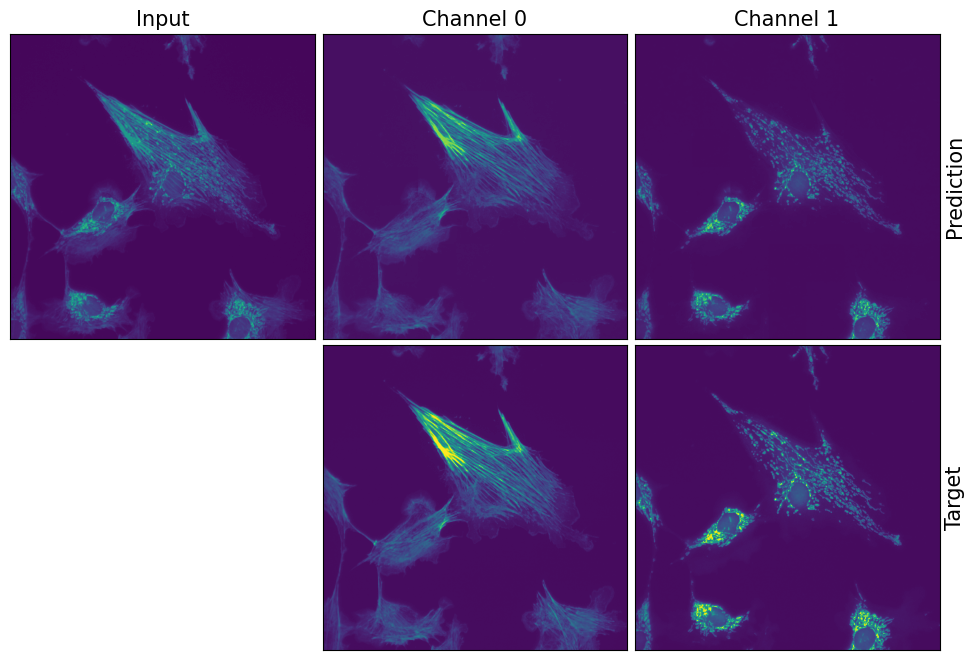

In [29]:
_,ax = plt.subplots(figsize=(12,8),ncols=3,nrows=2)
img_idx = 0
ax[0,0].imshow(target_stitched[img_idx,...,:nC] + target_stitched[img_idx,...,nC:])
ax[0,1].imshow(pred_stitched[img_idx,...,:nC])
ax[0,2].imshow(pred_stitched[img_idx,...,nC:])
ax[1,1].imshow(target_stitched[img_idx,...,:nC])
ax[1,2].imshow(target_stitched[img_idx,...,nC:])

ax[0,0].set_title('Input', fontsize=15)
ax[0,1].set_title('Channel 0', fontsize=15)
ax[0,2].set_title('Channel 1', fontsize=15)
ax[0,2].set_ylabel('Prediction', fontsize=15)
ax[1,2].set_ylabel('Target', fontsize=15)
ax[0,2].yaxis.set_label_position("right")
ax[1,2].yaxis.set_label_position("right")

ax[1,0].axis('off')

# reduce the space between the subplots
plt.subplots_adjust(wspace=0.02, hspace=0.02)
clean_ax(ax)

In [26]:
target_stitched.shape

(10, 2048, 2048, 2)

In [27]:
from core.psnr import RangeInvariantPsnr
ch0psnr, ch1psnr = [RangeInvariantPsnr(target_stitched[...,i]*1.0, pred_stitched[...,i]) for i in range(2)]
print(ch0psnr.mean().item(),ch1psnr.mean().item())


nan nan
